In [24]:
#written by Jacob "Coby" Abrahams, Secretary 2016-2017 with help from other skurves
#updated for python 3 and debugged by Alejandro López, Secretary 2018-2019, with help from Alison Dugas, Secretary 2017-2018,
#Umesh Padia, Webmaster 2017-2019, Jack Briones (CS class of 2020) and Coby Abrahams
from glob import glob
import copy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from warnings import simplefilter
simplefilter('ignore') # there's a matplotlib warning I always get

# Loading the ballots, hard coded for the format that google sheets outputs to
# .csvs. Returns a list of lists, where the first entry defines which candidate
# that position in the ballots refer to, and the rest of the entries are the 
# ballots themselves.
def LoadBallots(filename):
    spreadsheet = open(filename,'r')
    ballots = []
    ballot = ' '
    header = True
    while not ballot == []:
        ballot = spreadsheet.readline()
        ballot = ballot.split(',')[1:]
        if len(ballot) > 0:
            if len(ballot[-1]) > 2:
                ballot[-1].rstrip() # trimming end of line stuff
            if not header:
                #ballot = map(int,ballot) #commenting out this line just leaves the ballots as lists
                #which works fine as the Tennesee example shows -Alejandro
                if '\n' in ballot[-1]: #however you must add these lines to remove the '\n' from the last string in each
                    ballot[-1] = ballot[-1].strip('\n') #ballot, otherwise it'll miscount the last listed 
                    #candidate's votes -Alejandro
        ballots.append(ballot)
        header = False
    return ballots[:-1]

# Removes candidate i from all ballots in order to find a second place winner
def RemoveCandidate(ballots,i):
    for j in range(len(ballots)):
        ballots[j].pop(i)
    return ballots

# Makes example ballots accoring to the Tennessee example in the Ranked
# Pairs wikipedia page, assuming 100 votes
def MakeTennesseeBallots():
    memphis = [1,2,3,4]
    nashville = [4,1,2,3]
    chattanooga= [4,3,1,2]
    knoxville = [4,3,2,1]
    ballots = [['mem','nash','chat','knox']]
    for i in range(42):
        ballots.append(memphis)
    for i in range(26):
        ballots.append(nashville)
    for i in range(15):
        ballots.append(chattanooga)
    for i in range(17):
        ballots.append(knoxville)
    return ballots

# Returns a matrix where entry (i,j) is the number of ballots on which 
# candidate i beats candidate j. If (i,j) = (j,i), both are set to zero
# to avoid problems later.
def CountBallots(ballots):
    scores = copy.copy(ballots[1])
    for i in range(len(scores)):
        scores[i] = copy.copy(ballots[1])
        for j in range(len(scores[i])):
            scores[i][j] = 0
    for ballot in ballots[1:]:
        for i in range(len(ballot)):
            for j in range(len(ballot)):
                if ballot[i] < ballot[j]:
                    scores[i][j] += 1
                elif ballot[i] == ballot[j]:
                    scores[i][j] += 0.5
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            if scores[i][j] == scores[j][i]:
                scores[i][j] = 0
                scores[j][i] = 0
    return scores


# Identifies the largest value(s) in the scores matrix, adds that to a directed
# graph of candidates, where a->b means a beats b, and repeats. The graph is 
# stored in a dictionary where (key,value) is key->value. An edge is not
# drawn if it would complete a cycle. The source of the graph, if there is a
# single one, is the winner. If there is a cycle where everyone in the cycle
# beats everyone outside the cycle, a runoff is needed between the members of 
# the cycle. Note that a runoff will only work if people change their votes. 
def ConstructGraph(scores):
    graph = {}
    maxindex = FindMax(scores)
    while(maxindex != [(-1,-1)]):
        if len(maxindex) == 1:
            if maxindex[0][0] in graph.keys():
                graph[maxindex[0][0]].append(maxindex[0][1])
            else:
                graph[maxindex[0][0]] = [maxindex[0][1]]
            if CreatesCycle(graph,maxindex[0][0],maxindex[0][0],0) == True:
                graph[maxindex[0][0]].pop(-1)
            scores[maxindex[0][0]][maxindex[0][1]] = 0
            scores[maxindex[0][1]][maxindex[0][0]] = 0
        else:
            for index in maxindex:
                if index[0] in graph.keys():
                    graph[index[0]].append(index[1])
                else:
                    graph[index[0]] = [index[1]]
                scores[index[0]][index[1]] = 0
                scores[index[1]][index[0]] = 0
                tellmeyousethis = 0
                illgiveyouabeer = 0 #*this was Coby and 
                # with the implied condition that if you're 21+ only
        maxindex = FindMax(scores)
    return graph


    
# Returns tuple of indices (i,j) for the entry in the score matrix with the
# max value. If there is a tie, the tie is broken by which of the complementary
# locations, (j,i), indicating losing, is smallest. If there is still a tie, 
# both are returned, and a runoff election becomes a possibility.
def FindMax(scores):
    maxscore = 0.5 # this way if every entry in scores is 0, it doesn't update
    maxindex = [(-1,-1)]
    for r in range(len(scores)):
        for c in range(len(scores[r])):
            if scores[r][c] > maxscore:
                maxscore = scores[r][c]
                maxindex = [(r,c)]
            elif scores[r][c] == maxscore:
                if scores[c][r] < scores[maxindex[0][1]][maxindex[0][0]]:
                    maxindex = [(r,c)]
                elif scores[c][r] == scores[maxindex[0][1]][maxindex[0][0]]:
                    maxindex.append((r,c))
    if len(maxindex) == 2 and maxindex[0][0] == maxindex[1][0]:
        if scores[maxindex[0][1]][maxindex[1][1]] > scores[maxindex[1][1]][maxindex[0][1]]:
            maxindex = [maxindex[0]]
        elif scores[maxindex[0][1]][maxindex[1][1]] < scores[maxindex[1][1]][maxindex[0][1]]:
            maxindex = [maxindex[1]]
    return maxindex
    
# Checks if the provided graph contains a cycle which contains the relevant
# new edge.
def CreatesCycle(graph, currentkey, origin,depth):
    if depth > len(graph.keys())+1:
        return False
    if currentkey in graph.keys():
        for key in graph[currentkey]:
            if key == origin:
                return True
            if CreatesCycle(graph,key,origin,depth+1):
                return True
    return False

# Draws the graph.
def DrawGraph(graph,names):
    g = nx.DiGraph(graph)
    nx.draw_circular(g)
    pos = nx.circular_layout(g)
    labels = {}
    for i in graph.keys():
        labels[i] = names[i] # Labels can be made more meaningful if needed
    nx.draw_networkx_labels(g,pos,labels)
    plt.show()
    
def Run(filename,i=-1):
    if '.csv' not in filename:
        filename = glob('*{0}*.csv'.format(filename))[0]
        print(filename)
    ballots = LoadBallots(filename)
    if i != -1:
        ballots = RemoveCandidate(ballots,i)
    scores = CountBallots(ballots)
    graph = ConstructGraph(scores)
    names = [i.rstrip() for i in ballots[0]]
    
# Uncomment if you want specifics on 1 v. 1 races
    print(list(zip(names, CountBallots(ballots))))

    graph_keys = list(graph.keys())
    max_index = max(graph_keys)
    c = Counter(graph.keys())

    most_common = c.most_common(2) 
    print(most_common)

    print("p sure the winner is " + names[max(graph.keys(), key=lambda k: len(graph[k]))])
    DrawGraph(graph, names)

In [19]:
import os
os.listdir(".")

['.config',
 'Copy of President (Responses) - Form Responses 1.csv',
 'Treasurer (Responses) - Form Responses 1.csv',
 'Vice President (Responses) - Form responses 1.csv',
 '.ipynb_checkpoints',
 'sample_data']

[('Emma', [0, 22.5, 0, 43.0]), ('Michael', [37.5, 0, 40.5, 50.5]), ('Jonathan', [0, 19.5, 0, 46.0]), ('No', [17.0, 9.5, 14.0, 0])]
[(1, 1), (2, 1)]
p sure the winner is Michael


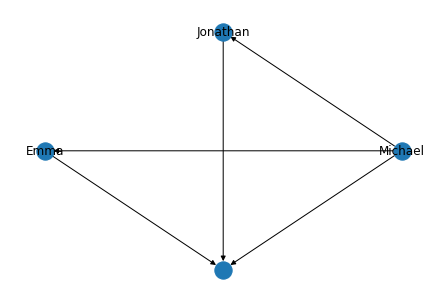

In [25]:
Run('./Treasurer (Responses) - Form Responses 1.csv')

In [ ]:
Run('/content/Vice President.csv')

FileNotFoundError: ignored

In [ ]:
Run('/test_3.csv')

In [ ]:
Run('/content/Secretary.csv')

In [ ]:
Run('/content/Treasurer.csv')

In [ ]:
Run('erections.csv')

In [ ]:
Run('seventh_survey.csv')